# Capstone Project: Recipe Analysis and Classification for Meal Kit Services

# Part 5: Ingredients and Recipe Recommendation System

For this section, I will explore techniques to find similar or complementary ingredients in my dataset. I will also develop a model that can recommend recipes to a user based on ingredients they have inputted.

### Contents:
1. [Pointwise Mutual Information](#1.-Pointwise-Mutual-Information)
2. [Word2Vec](#2.-Word2Vec)
3. [TF-IDF Model for Recipe Recommendations](#3.-TF-IDF-model-for-Recipe-Recommendations)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ast
import itertools
from gensim.models import word2vec

import nltk
from collections import Counter
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import heapq

import pickle

In [3]:
import sys  
sys.path.insert(0, '../src')
import ingredients_parser

In [5]:
# import dataset
data = pd.read_csv('../data/processed/cleaned_data.csv', sep=',', 
                   converters={'ingredients':ast.literal_eval,
                               'ingredientLines': ast.literal_eval})

## 1. Pointwise Mutual Information

### 1.1. Ingredient co-occurences

- In order to analyze which ingredients are complementary, the first step is to see how often ingredients are mentioned together (ingredient co-occurences)
- For this, I will find all the ingredient bigrams and use itertools to find the most frequently occuring bigram pairs

In [6]:
cooc_counts = Counter()
ing_count  = Counter()
for ingredients in data.ingredients:
    for ing in ingredients:
        ing_count[ing] += 1
    for (ing_a, ing_b) in itertools.combinations(set(ingredients), 2):
        if ing_a > ing_b:
            ing_a, ing_b = ing_b, ing_a
        cooc_counts[(ing_a, ing_b)] += 1

In [7]:
cooc_counts.most_common(10)

[(('pepper', 'salt'), 8277),
 (('clove', 'garlic'), 7003),
 (('onion', 'pepper'), 6912),
 (('onion', 'salt'), 6826),
 (('garlic', 'pepper'), 6141),
 (('garlic', 'salt'), 5993),
 (('garlic', 'onion'), 5903),
 (('clove', 'pepper'), 5302),
 (('clove', 'salt'), 5236),
 (('clove', 'onion'), 5143)]

In [8]:
ing_count.most_common(10)

[('pepper', 10365),
 ('salt', 10296),
 ('onion', 9702),
 ('garlic', 8460),
 ('clove', 7240),
 ('olive oil', 5510),
 ('chicken', 4768),
 ('tomato', 3981),
 ('black pepper', 3960),
 ('water', 3673)]

- The most common ingredient pairs are between peoper/salt/garlic/onion/clove
- However, these are also some of the most common ingredients therefore it is hard to assess whether these co-occurences are meaningful, or if it is only because these ingredients show up so frequently even alone

In [12]:
cooc_df = pd.DataFrame(((ing_a, ing_b, ing_count[ing_a], ing_count[ing_b], cooc) for (ing_a, ing_b), cooc in cooc_counts.items()), columns=['a', 'b', 'a_count', 'b_count', 'cooc'])
cooc_df.head()

,a,b,a_count,b_count,cooc
0,hoisin sauce,star anise,172,94,4
1,pineapple,star anise,782,94,2
2,spice,star anise,421,94,14
3,honey,star anise,764,94,11
4,star anise,water,94,3673,45


### 1.2. Pointwise Mutual Information

* In order to assess whether the ingredient cooccurences are meaningful, I will use Pointwise Mutual Information criterion
* In PMI, we can quantify the likelihood of co-occurence of two ingredients while taking into account that fact that it might be caused by the frequency of the single ingredients. The formula to calculate PMI computes the log probability of co-occurence scaled by the product of the single probability of occurence. More information on PMI can be found [here](https://medium.com/dataseries/understanding-pointwise-mutual-information-in-nlp-e4ef75ecb57a): 
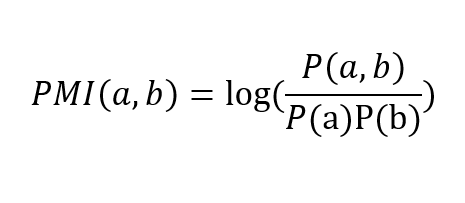

In [13]:
# P(A) is count(A)/number of recipes
# P(B) is count(B)/number of recipes
# P(A,B) is cooc(A,B)/number of cooc

p_a = cooc_df.a_count / sum(ing_count.values())
p_b = cooc_df.b_count / len(ing_count.values())
p_a_b = cooc_df.cooc / cooc_df.cooc.sum()
cooc_df['pmi'] = np.log(p_a_b / (p_a * p_b))

In [15]:
cooc_df.sort_values(by='pmi', ascending = False).head(10)

,a,b,a_count,b_count,cooc,pmi
53809,cane syrup,satsuma,1,1,1,4.620455
30294,clementine,mandarine,2,1,1,3.927308
30282,cointreau,mandarine,2,1,1,3.927308
57955,durum wheat,sparkling water,1,3,1,3.521842
52391,dungeness crab,shellfish stock,3,1,1,3.521842
54458,jerusalem artichoke,sunchoke,1,3,1,3.521842
8915,comt cheese,ramp,1,4,1,3.234160
56313,honeydew,melon,1,4,1,3.234160
32940,frise,hazelnut oil,4,1,1,3.234160
43732,cantaloupe,melon,1,4,1,3.234160


- The ingredient pairings with the highest PMI scores occur very infrequently overall - let's look at ingredients that occur at least 30 times in the dataset for better results

In [22]:
min_count = 30
cooc_df[(cooc_df.a_count >= min_count) & (cooc_df.b_count >= min_count)].sort_values('pmi', ascending=False).head(10)

,a,b,a_count,b_count,cooc,pmi
22338,pickled ginger,wasabi,40,60,15,-0.454719
33523,oat,pinot noir,38,34,8,-0.464050
22339,sushi rice,wasabi,38,60,13,-0.546527
17115,haddock,malt vinegar,39,30,6,-0.652545
15009,goat,goat cheese,37,67,12,-0.710249
3995,enchilada,enchilada sauce,54,192,50,-0.714002
5595,pecorino,romano cheese,60,47,13,-0.759088
17208,lasagna,ricotta cheese,85,141,54,-0.781972
193,rutabaga,turnip,30,92,12,-0.817625
7757,blue cheese,stilton,44,77,14,-0.868483


- If we only look at ingredients that occur at least 30 times in the data set, the pairing with the highest PMI is pickled ginger and wasabi (which does make sense as this is a common pairing in Japanese meals)

In [24]:
min_count = 30
cooc_df[(cooc_df.a_count >= min_count) & (cooc_df.b_count >= min_count) & (cooc_df.cooc > 1)].sort_values('pmi', ascending=True).head(10)

,a,b,a_count,b_count,cooc,pmi
12293,cheese,fish sauce,3059,709,2,-9.276097
44259,cheese,mirin,3059,596,2,-9.102482
31927,ginger,parmesan cheese,3049,764,3,-8.942070
28210,cumin,mirin,2438,596,2,-8.875572
15525,bay leaf,sesame oil,1497,868,2,-8.763808
22315,chorizo,soy sauce,445,2444,2,-8.585864
43250,sauerkraut,soy sauce,389,2444,2,-8.451369
49228,mozzarella cheese,soy sauce,576,2444,3,-8.438432
22134,parmesan cheese,soy sauce,764,2444,4,-8.433210
21111,chorizo,ginger,445,3049,3,-8.401576


- If we look at the ingredient pairings with the worst PMI scores, many are cheeses with soy sauce or fish sauce which do seem like ingredients that would not be found in many recipes together

### 1.3 Matrix Factorization

- In order to display the top 10 most complementary ingredients based on the PMI  I will first create a sparse matrix with PMI values for all ingredient combinations
- I will then use truncated SVD to reduce the number of features
- Lastly, I will use cosine similarity, which calculates the similarity between two vectors by taking the cosine of the angle between them.
- I will create a function that uses cosine similarity to find the similarity between the SVD vector of a particular ingredient and every other ingredient in the matrix, and return the ingredients with the highest similarity

In [34]:
# duplicate, inverse and concatenate the cooc dataframe so all ingredients will exist in column a

# create copy
cooc_df_t = cooc_df.copy()

# invert data
cooc_df_t['a'] = cooc_df['b']
cooc_df_t['a_count'] = cooc_df['b_count']
cooc_df_t['b'] = cooc_df['a']
cooc_df_t['b_count'] = cooc_df['a_count']

# concatenate 
data_df = pd.concat([cooc_df, cooc_df_t])

In [35]:
# create a sparse matrix with PMI values for all ingredient combinations
rows_idx, row_keys = pd.factorize(data_df.a)
cols_idx, col_keys = pd.factorize(data_df.b)
values = data_df.pmi

matrix = csr_matrix((values, (rows_idx, cols_idx)))
key_to_row = {key: idx for idx, key in enumerate(row_keys)}

* The singular-value decomposition/ SVD is a dimension reduction technique for matrices that reduces the matrix into its component.
* SVD is a popular method for dimensionality reduction that works well with sparse data
* Truncated SVD will produce a matrices with the specified number of columns, which means that it will drop off all features except the number of features provided (200 in my case)

In [36]:
svd = TruncatedSVD(200)
factors = svd.fit_transform(matrix)

In [39]:
def most_complementary(ingredient, topn=10):
    if ingredient not in key_to_row:
        print("Unknown ingredient.")
    factor = factors[key_to_row[ingredient]]
    cosines = cosine_similarity([factor], factors)[0]
    indices = cosines.argsort()[::-1][:topn + 1]
    keys = [row_keys[idx] for idx in indices if idx != key_to_row[ingredient]]
    return keys, cosines[indices]

def display_most_complementary(ingredient, topn=10):
    print("- Most complementary to '{}'".format(ingredient))
    for similar_ing, score in zip(*most_complementary(ingredient, topn)):
        print("  . {} : {:.2f}".format(similar_ing, score)) 

In [40]:
display_most_complementary('pasta')

- Most complementary to 'pasta'
  . wheat : 1.00
  . hot sauce : 0.85
  . cauliflower : 0.82
  . jalapeno : 0.82
  . spinach : 0.82
  . tomato sauce : 0.82
  . sausage : 0.81
  . garlic powder : 0.81
  . zucchini : 0.81
  . bun : 0.81


In [42]:
display_most_complementary('garlic')

- Most complementary to 'garlic'
  . clove : 1.00
  . onion : 1.00
  . pepper : 0.99
  . salt : 0.98
  . olive oil : 0.98
  . black pepper : 0.95
  . chicken : 0.95
  . water : 0.93
  . tomato : 0.93
  . butter : 0.92


In [43]:
display_most_complementary('tomato')

- Most complementary to 'tomato'
  . black pepper : 1.00
  . onion : 0.93
  . clove : 0.92
  . olive oil : 0.92
  . lemon : 0.92
  . garlic : 0.92
  . water : 0.92
  . chicken : 0.91
  . pepper : 0.91
  . butter : 0.90


## 2. Word2Vec 

- Another method to find similar ingredients is using Word2vec
- Word2vec is an algorithm that uses recurrent neural networks to learn the relationship between words using the context (or neighboring words), and encodes these relationships in a vector. We can cluster words and do operations based on these vectors

In [44]:
num_features = 300   # Word vector dimensionality                      
context = 1        # Context window size; 
downsampling = 1e-3   # threshold for configuring which higher-frequency words are randomly downsampled

# Initialize and train the model 
model = word2vec.Word2Vec(data.ingredients, vector_size=num_features, window = context, sample = downsampling)


In [45]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [46]:
all_ingredients = flatten(data.ingredients)

In [47]:
all_ingredients = list(set(all_ingredients))

In [48]:
most_sim_list = []
corpus_sim_dict = {}
input_list = []
for i in all_ingredients:
    try:
        corpus_sim_dict.update({i:model.wv.most_similar(i)})
    except KeyError:
        pass

In [49]:
sim_df = pd.DataFrame([])
for key,value in corpus_sim_dict.items():
    for i in value:
        sim_df = sim_df.append(pd.DataFrame({'Ingredient': key, 'Similar Ingredient':i[0],'Word2Vec Value': i[1]}, index=[0]), ignore_index=True)

In [50]:
model.wv.most_similar('pasta')

[('penne', 0.9345084428787231),
 ('spaghetti', 0.9250423312187195),
 ('marinara sauce', 0.9235700964927673),
 ('parmesan cheese', 0.8968974351882935),
 ('ricotta', 0.8952025175094604),
 ('grape', 0.8798729777336121),
 ('cottage cheese', 0.853447437286377),
 ('tomato sauce', 0.8496817350387573),
 ('pizza sauce', 0.8482288122177124),
 ('pecorino', 0.8398560881614685)]

In [51]:
model.wv.most_similar('garlic')

[('bell pepper', 0.7892811894416809),
 ('vegetable oil', 0.757842481136322),
 ('cod', 0.7538741827011108),
 ('cashew', 0.7232766151428223),
 ('tahini', 0.7214565873146057),
 ('prune', 0.7179772853851318),
 ('mussel', 0.7147061228752136),
 ('pumpkin', 0.707627534866333),
 ('galangal', 0.6998398303985596),
 ('lemon', 0.6978022456169128)]

In [52]:
model.wv.most_similar('tomato')

[('kosher salt', 0.8461099863052368),
 ('kale', 0.8244799971580505),
 ('grape', 0.7872694134712219),
 ('kidney bean', 0.7862275242805481),
 ('artichoke', 0.773651123046875),
 ('bomba rice', 0.7654609680175781),
 ('andouille sausage', 0.7566682696342468),
 ('tilapia', 0.7312453985214233),
 ('jalapeno', 0.7257533669471741),
 ('scallop', 0.715468168258667)]

In [53]:
model.wv.most_similar('white rice')

[('halibut', 0.8599970936775208),
 ('cauliflower', 0.8528781533241272),
 ('cilantro', 0.8497830033302307),
 ('capsicum', 0.8228902816772461),
 ('mushroom', 0.8111796975135803),
 ('pork loin', 0.8041980266571045),
 ('orange', 0.8040165305137634),
 ('radish', 0.7995124459266663),
 ('mung bean', 0.7959045767784119),
 ('sesame oil', 0.792885422706604)]

## 3. TF-IDF model for Recipe Recommendations

* For this section, I will create a model that provides a user with recipe suggestions based on ingredients inputted. This model will be deployed as a telgram bot
* I will used TF-IDF to vectorize the list of ingredients, and fit the TF-IDF vectorizer on the new list of ingredients the user provides
* I will then calculate the cosine similarity between the TF-IDF vector of user-inputted ingredients and the vector for every recipe in the dataset, and return the recipes with the top 5 highest cosine similarities
* By using TF-IDF, the recipes suggested should be more sensitive to ingredients that appear less commonly across all recipes (i.e. if a user inputs pepper and wasabi, the recipes generated should contain wasabi moreso than pepper which is a very common ingredient)

In [54]:
data['ingredients_parsed'] = data['ingredients'].apply(lambda x: ' '.join(x).lower())

tvec = TfidfVectorizer(binary=True, max_df = .95)
tvec.fit(data.ingredients_parsed.tolist())
tvec_recipe = tvec.transform(data['ingredients_parsed'])

# save the tfidf model and encodings
with open('../models/recipe_recommender/tvec.pkl', "wb") as f:
    pickle.dump(tvec, f)
with open('../models/recipe_recommender/tvec_recipe.pkl', "wb") as f:
     pickle.dump(tvec_recipe, f)

In [55]:
def get_recipes(input_ingredients):
    with open('../models/recipe_recommender/tvec_recipe.pkl', 'rb') as f:
        tvec_encodings = pickle.load(f)
    
    with open('../models/recipe_recommender/tvec.pkl', "rb") as f:
        tvec = pickle.load(f)
    
    input_ingredients = [' '.join(ingredients_parser.clean_ingredients(input_ingredients))]
    ingredients_tfidf = tvec.transform(input_ingredients)
    
    #generate cosine similarties
    cos_sim = map(lambda x: cosine_similarity(ingredients_tfidf, x), tvec_encodings)
    scores = list(cos_sim)
    
    #index for top 5 recipes
    top = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:5]
    
    #dataframe to input top 5 recipes
    recommendation = pd.DataFrame(columns = ['recipe', 'ingredients', 'score', 'source', 'cuisine'])
    
    #populate dataframe from index
    count = 0
    for i in top:
        recommendation.at[count, 'recipe'] = data.name[i]
        recommendation.at[count, 'cuisine'] = data.cuisine[i]
        recommendation.at[count, 'ingredients'] = data.ingredientLines[i]
        recommendation.at[count, 'source'] = data.source[i]
        recommendation.at[count, 'score'] = "{:.3f}".format(float(scores[i]))
        count += 1
    
    #return dataframe
    return recommendation

In [56]:
get_recipes('chicken, soy sauce, rice')

,recipe,ingredients,score,source,cuisine
0,takeout style chinese spare ribs (take 2),"[5 cloves freshly minced garlic, 1 tablespoon ...",0.000,http://thewoksoflife.com/2014/03/takeout-style...,Chinese
1,corned beef and vegetables,"[1 whole corned beef brisket (6 to 8 pounds), ...",0.000,http://www.goingmywayz.com/corned-beef-vegetab...,Irish
2,kung pao chicken,"[1 tablespoon soy sauce, 2 teaspoons Chinese r...",0.000,http://www.epicurious.com/recipes/food/views/k...,Chinese
3,"pulpo gallego, spanish octopus with paprika","[2 to 3 pounds octopus, 1 bunch of parsley, To...",0.000,https://honest-food.net/pulpo-gallego-recipe-o...,Spanish
4,pork carnitas,"[4 pound boneless pork butt, fat trimmed and c...",0.000,http://www.mykitchenescapades.com/2012/11/pork...,Mexican


In [57]:
get_recipes('pineapple, soy sauce, noodles')

,recipe,ingredients,score,source,cuisine
0,takeout style chinese spare ribs (take 2),"[5 cloves freshly minced garlic, 1 tablespoon ...",0.000,http://thewoksoflife.com/2014/03/takeout-style...,Chinese
1,corned beef and vegetables,"[1 whole corned beef brisket (6 to 8 pounds), ...",0.000,http://www.goingmywayz.com/corned-beef-vegetab...,Irish
2,kung pao chicken,"[1 tablespoon soy sauce, 2 teaspoons Chinese r...",0.000,http://www.epicurious.com/recipes/food/views/k...,Chinese
3,"pulpo gallego, spanish octopus with paprika","[2 to 3 pounds octopus, 1 bunch of parsley, To...",0.000,https://honest-food.net/pulpo-gallego-recipe-o...,Spanish
4,pork carnitas,"[4 pound boneless pork butt, fat trimmed and c...",0.000,http://www.mykitchenescapades.com/2012/11/pork...,Mexican


In [58]:
get_recipes('parmesan, fettucine')

,recipe,ingredients,score,source,cuisine
0,takeout style chinese spare ribs (take 2),"[5 cloves freshly minced garlic, 1 tablespoon ...",0.000,http://thewoksoflife.com/2014/03/takeout-style...,Chinese
1,corned beef and vegetables,"[1 whole corned beef brisket (6 to 8 pounds), ...",0.000,http://www.goingmywayz.com/corned-beef-vegetab...,Irish
2,kung pao chicken,"[1 tablespoon soy sauce, 2 teaspoons Chinese r...",0.000,http://www.epicurious.com/recipes/food/views/k...,Chinese
3,"pulpo gallego, spanish octopus with paprika","[2 to 3 pounds octopus, 1 bunch of parsley, To...",0.000,https://honest-food.net/pulpo-gallego-recipe-o...,Spanish
4,pork carnitas,"[4 pound boneless pork butt, fat trimmed and c...",0.000,http://www.mykitchenescapades.com/2012/11/pork...,Mexican
